In [1]:
#-----------------------------------------------------------
# IMPORT ALL NECESSARY MODULES
#-----------------------------------------------------------
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


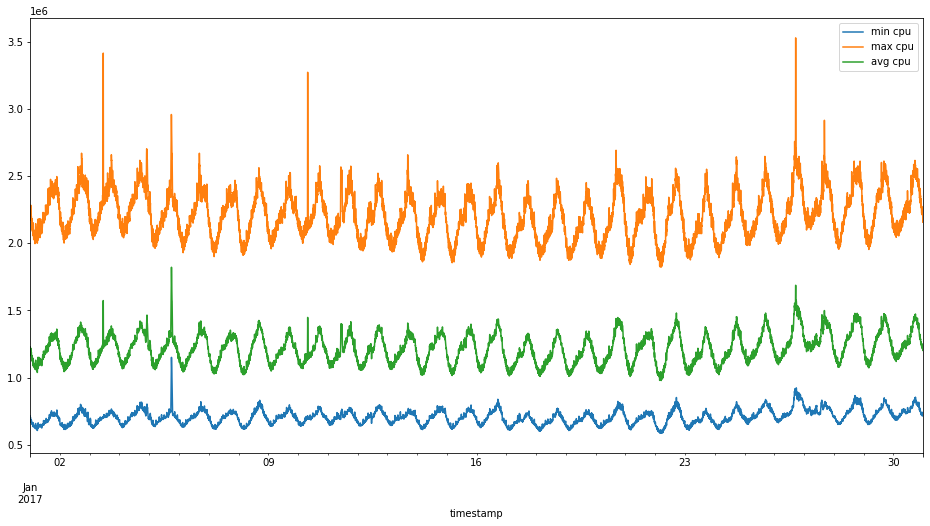

In [3]:
#-----------------------------------------------------------
# LOAD THE DATASET AND PLOT THE OBSERVATIONS
#-----------------------------------------------------------
df = pd.read_csv('../input/azure-data/AzureReadings_at_a_timestamp.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()
df.plot(figsize=(16, 8))
plt.show()

In [4]:
#-----------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
#-----------------------------------------------------------
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH : ]

In [5]:
#-----------------------------------------------------------
# SCALING VALUES
#-----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

In [6]:
#-----------------------------------------------------------
# GENERATOR TO GENERATE DATA TO FEED INTO MODEL
#-----------------------------------------------------------
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset)- n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [7]:
#-----------------------------------------------------------
# DEFINING INPUTS AND EXPECTED OBSERVATIONS
# SPECIFYING TIMESTEPS TO LOOK BACK INTO PAST OBSERVATIONS
#-----------------------------------------------------------
TIME_STEPS = 400
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [11]:
#-----------------------------------------------------------
# USING A INDEPENDENT RNN MODEL FOR PREDICTION ON TIME SERIES
# DEFINING 'RECURRENT_MAX' ACCORDING TO PAPER
#-----------------------------------------------------------
RECURRENT_MAX = pow(2, 1 / TIME_STEPS)
model = tf.keras.models.Sequential()
model.add(IndRNN(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(IndRNN(512,return_sequences=False))

model.add(tf.keras.layers.Dense(3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ind_rnn_2 (IndRNN)           (None, 400, 512)          2048      
_________________________________________________________________
ind_rnn_3 (IndRNN)           (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 266,243
Trainable params: 266,243
Non-trainable params: 0
_________________________________________________________________


In [12]:
#-----------------------------------------------------------
# DEFINING CALLBACKS AND COMPILING MODEL
#-----------------------------------------------------------
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0000001,)
callbacks = [es , lr_red]
#adamOpt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [15]:
history = model.fit(X_train, y_train, 
                    epochs=200, 
                    validation_split=0.25, 
                    batch_size=512, 
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

Epoch 1/200
10/10 [==============================] - 6s 589ms/step - loss: 0.0147 - val_loss: 0.0162 - lr: 3.2000e-07
Epoch 2/200
10/10 [==============================] - 5s 545ms/step - loss: 0.0147 - val_loss: 0.0162 - lr: 3.2000e-07
Epoch 3/200
10/10 [==============================] - 5s 540ms/step - loss: 0.0147 - val_loss: 0.0162 - lr: 3.2000e-07
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-07.
10/10 [==============================] - 6s 587ms/step - loss: 0.0147 - val_loss: 0.0162 - lr: 3.2000e-07
Epoch 5/200
10/10 [==============================] - 5s 545ms/step - loss: 0.0147 - val_loss: 0.0162 - lr: 1.0000e-07
Epoch 6/200
10/10 [==============================] - 6s 589ms/step - loss: 0.0147 - val_loss: 0.0162 - lr: 1.0000e-07
Epoch 7/200
10/10 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00007: ReduceLROnPlateau reducing learning rate to 1e-07.
10/10 [=================

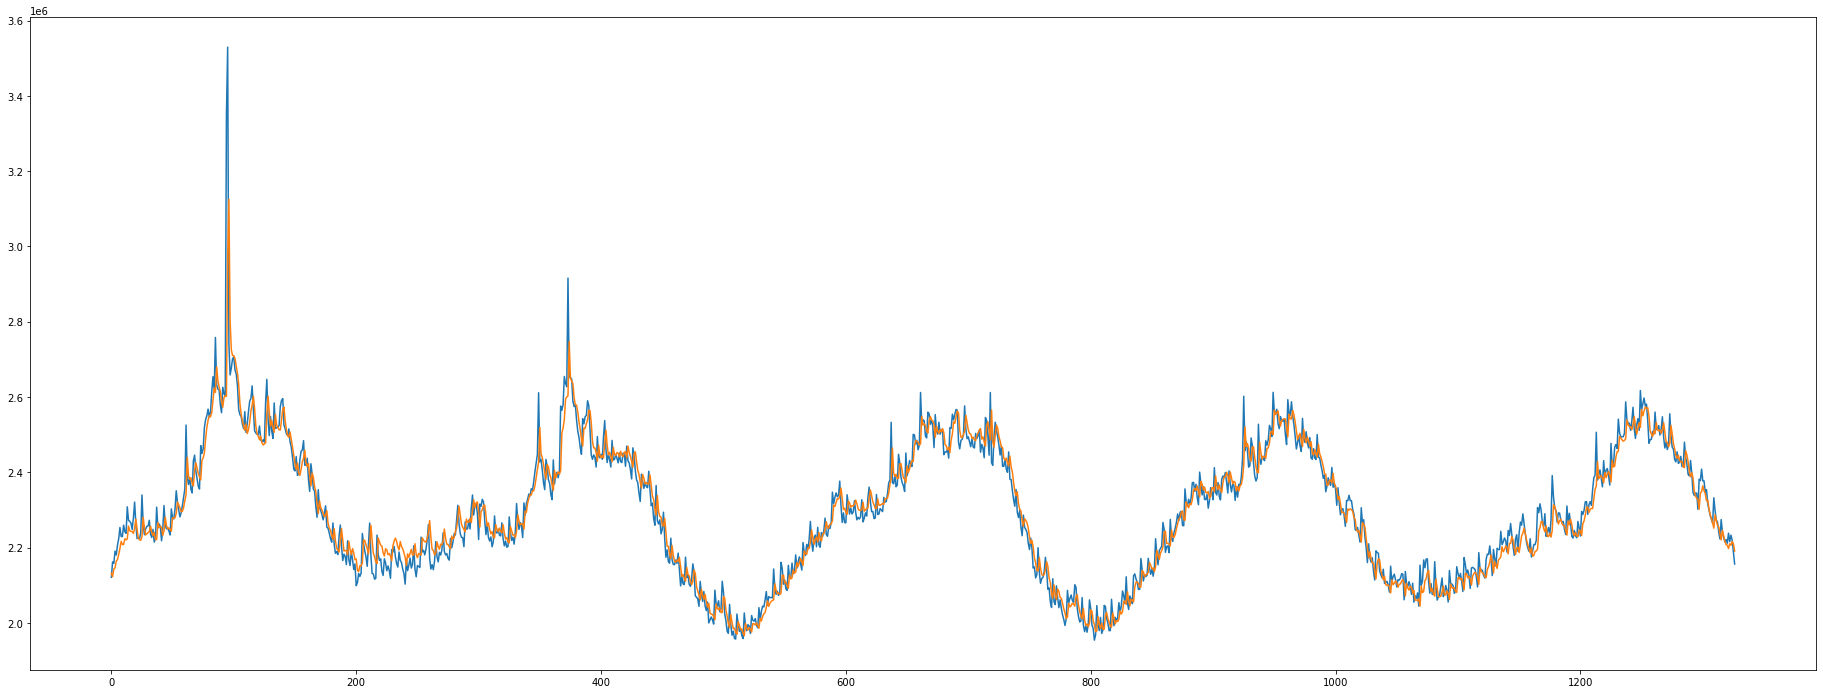

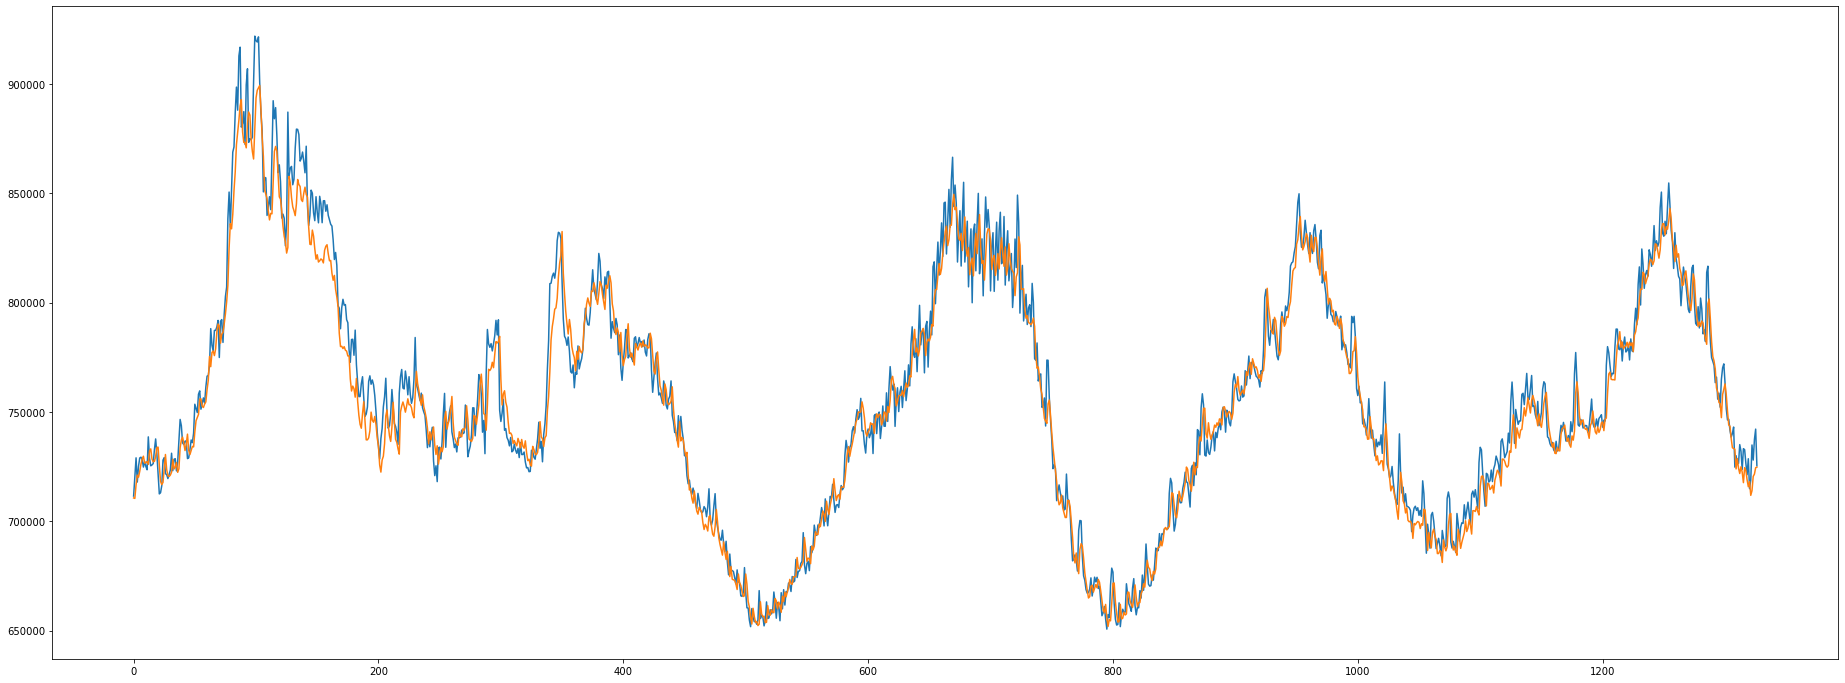

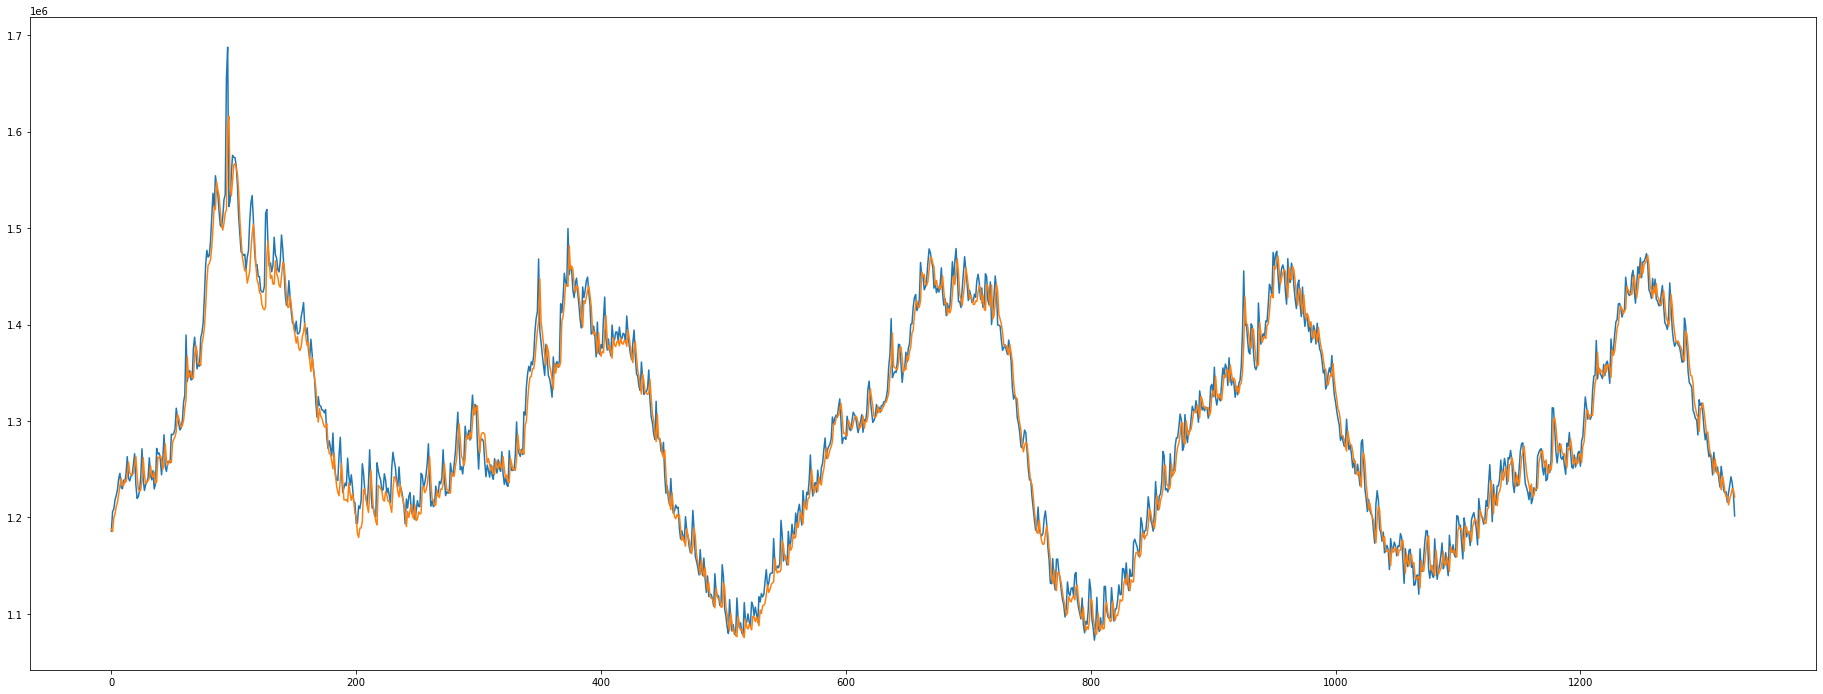

In [16]:
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY= pd.DataFrame(y_test,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(preds,columns=['min_cpu','max_cpu','avg_cpu'])


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [19]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error


testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 30128.65 RMSE
Test Score: 131.286369 MAE
Test Score: 1.120023 MAPE
